# Workshop 5. Рекомендательная система

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже. 

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [1]:
import pandas as pd

In [2]:
anime = pd.read_csv('anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
ratings = pd.read_csv('anime/rating.csv.zip')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Обзор данных

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

In [4]:
anime.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 32281 to 26081
Data columns (total 6 columns):
name        12017 non-null object
genre       12017 non-null object
type        12017 non-null object
episodes    12017 non-null object
rating      12017 non-null float64
members     12017 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 657.2+ KB


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
user_id     int64
anime_id    int64
rating      int64
dtypes: int64(3)
memory usage: 178.8 MB


<Figure size 1440x1440 with 0 Axes>

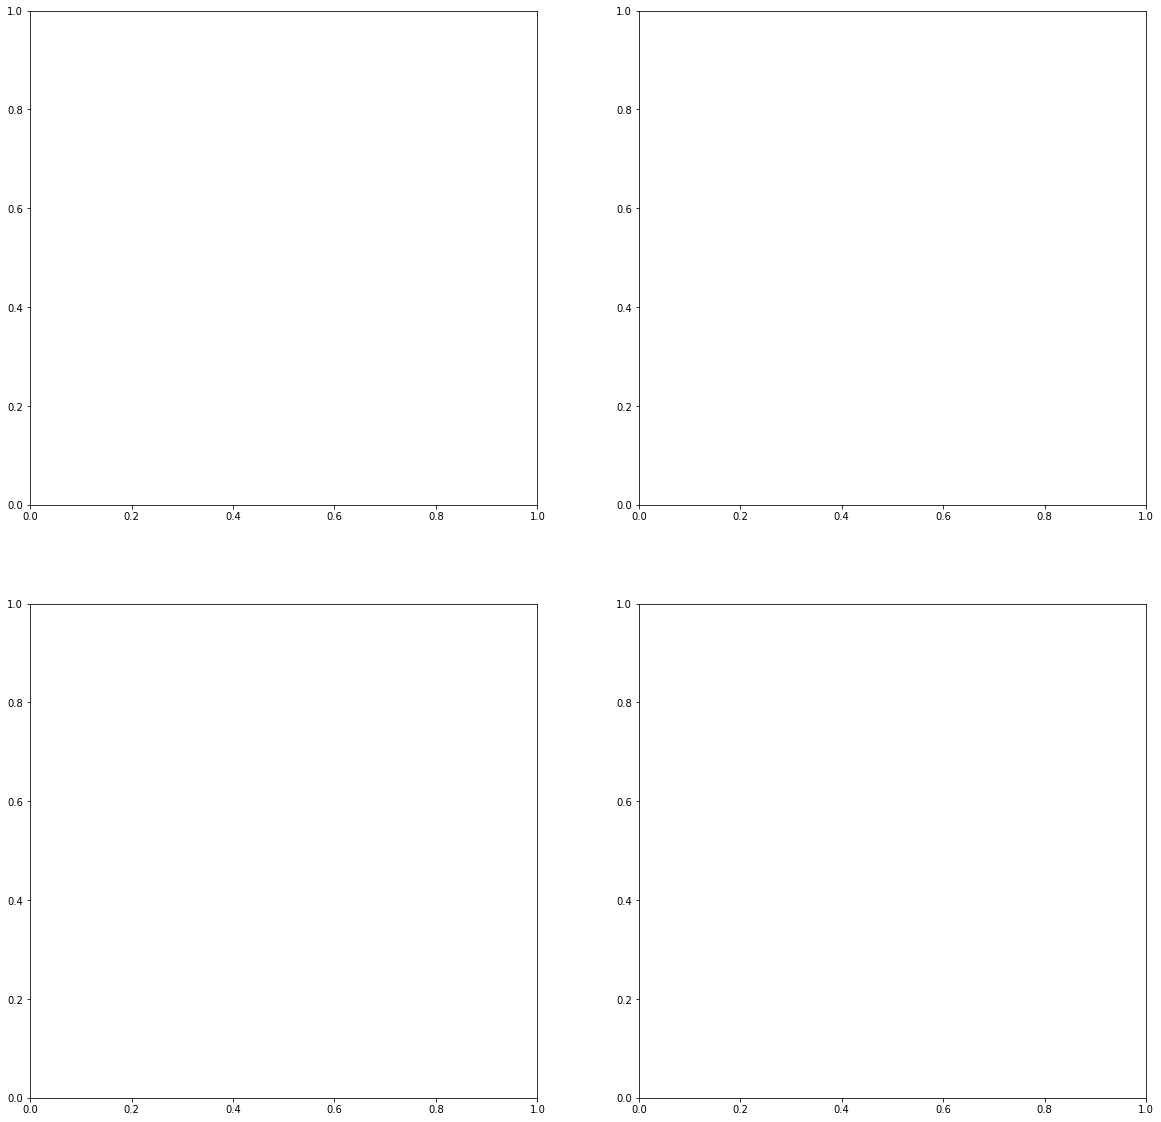

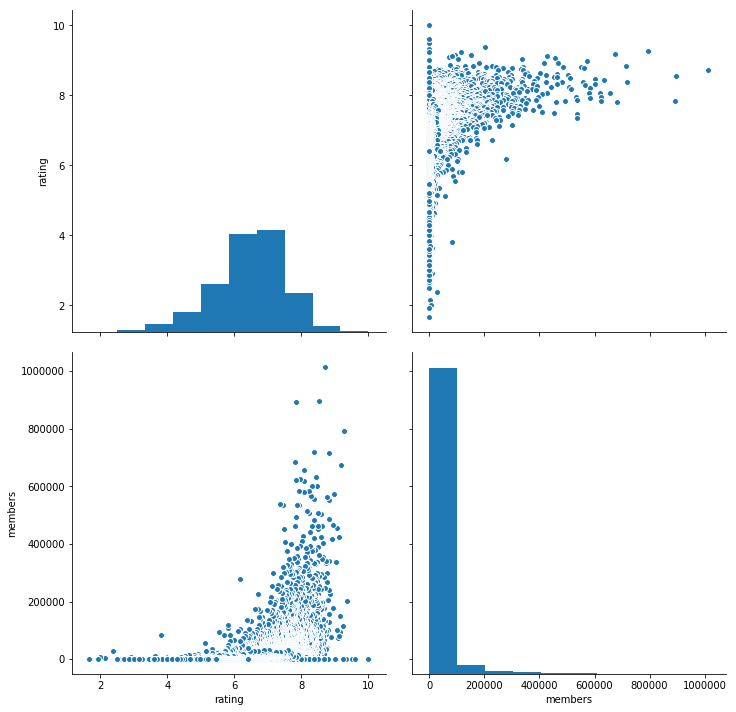

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(20,20))
sns.pairplot(data=anime["type,episodes,rating,members".split(',')], size=5)


## Жанры

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)

In [10]:
movie_anime = anime[anime["type"] == "Movie"]



from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. В конфе происходит flatten - уплощение списка скписков в один список.
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = movie_anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))



Genres=['Magic', 'Game', 'Romance', 'Samurai', 'Sports', 'Dementia', 'Hentai', 'Drama', 'Adventure', 'Shounen Ai', 'Demons', 'Action', 'Thriller', 'Horror', 'Josei', 'Psychological', 'Music', 'Super Power', 'Vampire', 'Shoujo', 'Space', 'Kids', 'Parody', 'Mystery', 'Police', 'Shounen', 'School', 'Military', 'Slice of Life', 'Cars', 'Harem', 'Seinen', 'Ecchi', 'Mecha', 'Fantasy', 'Comedy', 'Martial Arts', 'Supernatural', 'Sci-Fi', 'Historical']
len=40


In [11]:
pd_movie_anime = pd.DataFrame(index=movie_anime.index)

for g in genres:
    pd_movie_anime[g] = movie_anime['genre'].str.contains(g).astype(int)


In [12]:

pd_movie_anime.head(30)

pd_movie_anime.set_index(movie_anime["name"])

,Magic,Game,Romance,Samurai,Sports,Dementia,Hentai,Drama,Adventure,Shounen Ai,...,Harem,Seinen,Ecchi,Mecha,Fantasy,Comedy,Martial Arts,Supernatural,Sci-Fi,Historical
name,,,,,,,,,,,,,,,,,,,,,
Kimi no Na wa.,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
Koe no Katachi,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Sen to Chihiro no Kamikakushi,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
Ookami Kodomo no Ame to Yuki,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Mononoke Hime,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Suzumiya Haruhi no Shoushitsu,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
Mushishi Zoku Shou: Suzu no Shizuku,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,1
Howl no Ugoku Shiro,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0


In [31]:
pd_movie_anime.sum()

Magic            108
Game              14
Romance          165
Samurai           29
Sports           115
Dementia         172
Hentai             8
Drama            473
Adventure        634
Shounen Ai         5
Demons            43
Action           546
Thriller          25
Horror            66
Josei              2
Psychological     67
Music             85
Super Power       92
Vampire            8
Shoujo            85
Space             94
Kids             444
Parody            31
Mystery           86
Police            49
Shounen          372
School           100
Military         105
Slice of Life    166
Cars              12
Harem              7
Seinen            56
Ecchi             30
Mecha            163
Fantasy          570
Comedy           678
Martial Arts      48
Supernatural     155
Sci-Fi           397
Historical       225
dtype: int64

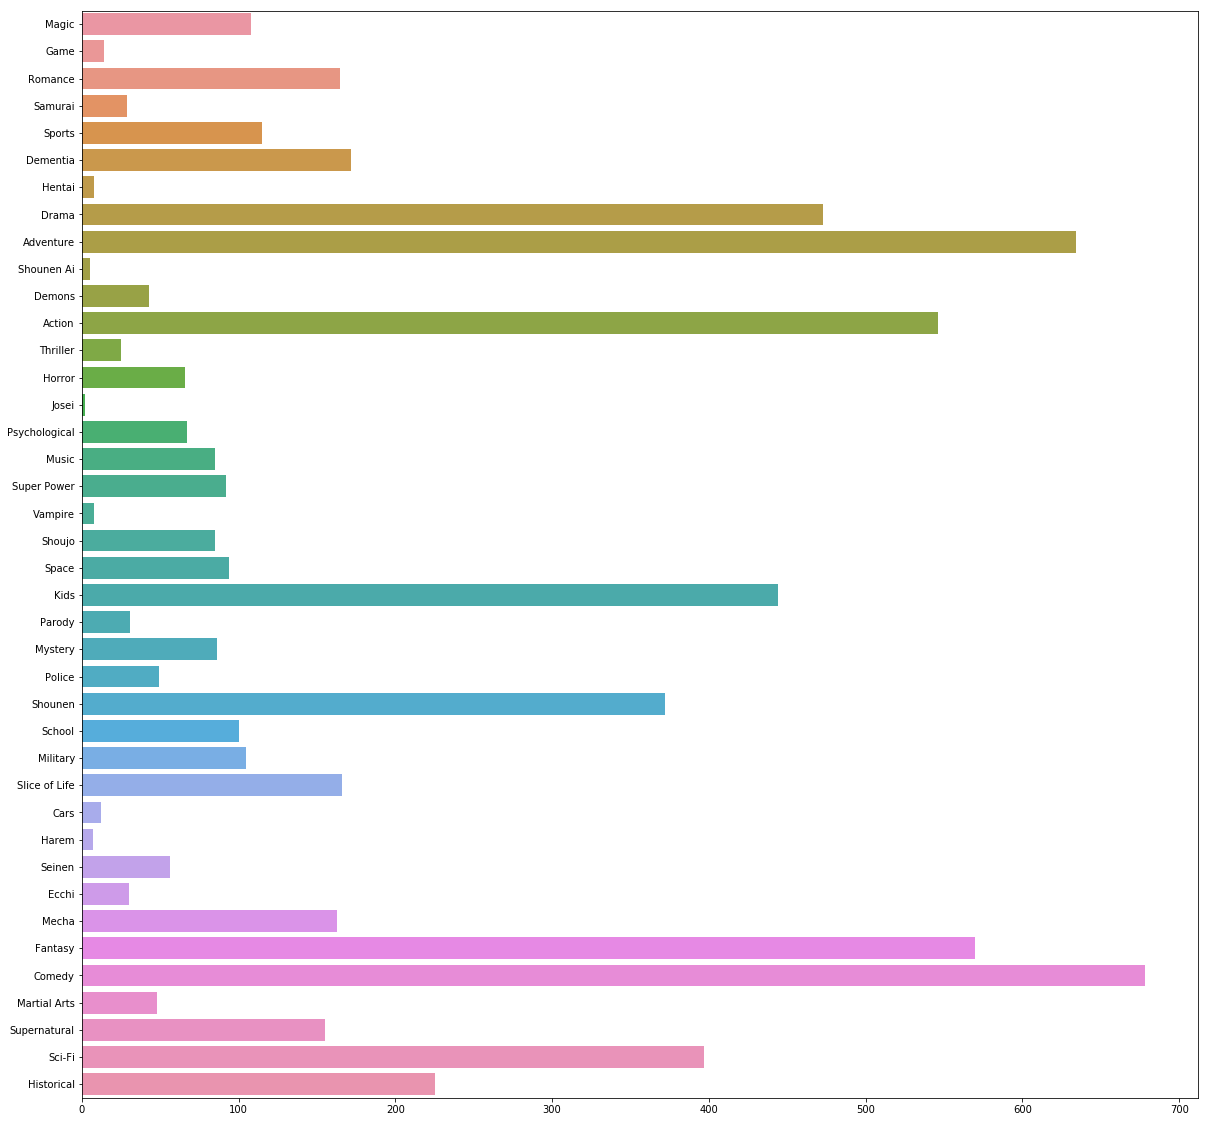

In [38]:

plt.figure(figsize=(20,20))
sns.barplot(x=pd_movie_anime.sum(),y=genres)

## Рейтинг

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

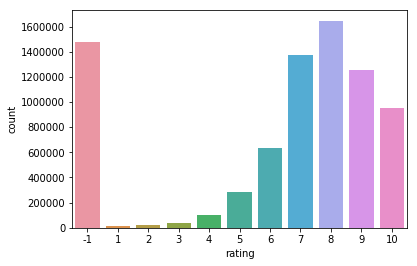

In [13]:
sns.countplot(x="rating", data=ratings)

## Фильтрация данных

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [74]:


anime_watches = pd.DataFrame(index=ratings['anime_id'],data=ratings['anime_id'].value_counts())

user_rating = pd.DataFrame(index=ratings['user_id'].unique(),data=ratings['user_id'].value_counts())

anime_watches = anime_watches.rename(columns={"anime_id": "count_review"})

user_rating = user_rating.rename(columns={"user_id": "count_rating"})

print(anime_watches)

print(user_rating)

anime_watches


          count_review
anime_id              
20               25925
24                7153
79                7112
226              27506
241               4180
355              11950
356              14915
442               7846
487               3210
846               4894
936               6296
1546              1668
1692               367
1836              1566
2001             19337
2025             15591
2144              5883
2787              8644
2993             13867
3455              8764
4063              7924
4214             10285
4224             24283
4581              2812
4744              4662
4898             15583
4999              5518
5034              2227
5277              5221
5667              3858
...                ...
10490             3990
10588             4508
11021             1907
11111            20130
11241             3334
11411               24
11701             4308
11741            12047
11751             1498
11757            30583
11759      

,count_review
anime_id,
20,25925
24,7153
79,7112
226,27506
241,4180
355,11950
356,14915
442,7846
487,3210


In [84]:

%time anime_ratings = ratings \
    .join(user_rating, on="user_id") \
    .join(anime, on="anime_id", lsuffix="_a") \
#     .join(anime_watches, on="anime_id") \

anime_ratings.head()

CPU times: user 4.85 s, sys: 1.43 s, total: 6.28 s
Wall time: 3.11 s


,user_id,anime_id,rating_a,count_rating,name,genre,type,episodes,rating,members
0,1,20,-1,153,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
1,1,24,-1,153,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553.0
2,1,79,-1,153,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24,7.31,158772.0
3,1,226,-1,153,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511.0
4,1,241,-1,153,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11,6.69,84395.0


In [96]:

for i in anime_ratings.index:
    print(anime_ratings[i]["rating_a"])
    
anime_ratings.head()

KeyError: 0

In [86]:
anime_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 10 columns):
user_id         int64
anime_id        int64
rating_a        int64
count_rating    int64
name            object
genre           object
type            object
episodes        object
rating          float64
members         float64
dtypes: float64(2), int64(4), object(4)
memory usage: 596.1+ MB


In [88]:
mean = anime_ratings['count_rating'].mean()
mean

326.77587113566784

## Матрица user-item

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько занимет в памяти эта матрица.

## Понижение размерности

kNN будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kNN и получите результаты).

## Обучение kNN

Обучим kNN, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kNN
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

## Top 15 аниме

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере. 
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга. 
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

## Top 5 жанров

Если соеднить таблицу с аниме с таблицей жанров, то можно найти топ жанров для каждого кластера. Придумайте сами как это сделать, так как тут много способов:

- найти средний рейтинг для аниме каждого жанра
- посчитать сколько представителей каждого жанра есть среди top100 аниме кластера (кстати работает лучше)
- ???